In [1]:
#%pylab inline
#get epochs using your mne-python pipeline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import sys
import os

import numpy as np
from sklearn.preprocessing import MinMaxScaler
import mne

#os.chdir('/m/nbe/project/rtmeg/problearn/mneflow/')
os.chdir('/u/20/vranoug1/unix/OPM-BCI/mneflow-dev/mneflow/')
import mneflow
from mneflow import keras_models

from mneflow.keras_utils import plot_output, plot_history
from mneflow.keras_utils import r_square, soft_acc, rmse

# Force enable eager execution after importing mneflow
tf.compat.v1.enable_eager_execution()
mne.set_log_level(verbose='CRITICAL')


path = '/m/nbe/work/vranoug1/OPM-BCI/datasets/'
fname = 'sim_2_erps_50nA.npz'


import_opt = dict(fs=500,
                  savepath='../tfr/',
                  out_name=fname,
                  input_type='trials',
                  target_type='float',
                  val_size=0.2,
                  array_keys={'X': 'X', 'y': 'y'},
                  # picks=None, target_picks=None,
                  scale=True,
                  scale_interval=None,
                  # crop_baseline=True,
                  decimate=None,
                  bp_filter=False,
                  overwrite=False,
                  test_set='holdout')

meta = mneflow.produce_tfrecords([path+fname], **import_opt)
dataset = mneflow.Dataset(meta, train_batch=100, class_subset=None, pick_channels=None, decim=None)

Metadata file found, restoring


In [2]:
sys.path
print('---------\n'+mneflow.__file__)
print('tf version: '+tf.__version__)
print('executing eagerly: '+str(tf.executing_eagerly())+'\n---------')

---------
/u/20/vranoug1/unix/.conda/envs/py3ml/lib/python3.7/site-packages/mneflow/__init__.py
tf version: 1.14.0
executing eagerly: True
---------


In [3]:
# specify model parameters
graph_specs = dict(n_ls=32,  # number of latent factors
                   filter_length=64,  # convolutional filter length
                   pooling=32,  # convlayer pooling factor
                   stride=16,  # stride parameter for pooling layer
                   padding='SAME',
                   dropout=.5,
                   nonlin=tf.nn.relu,
                   pool_type='max',
                   out_dim=np.prod(meta['y_shape']),
                   axis=1,
                   y_shape=meta['y_shape'],
                   model_path = import_opt['savepath'],  # not used at the moment
                   # regularization parameters
                   l1=3e-4,
                   l2=0,
                   # LSTM parameters
                   rnn_units=np.prod(meta['y_shape']),
                   rnn_dropout=0.0,
                   rnn_nonlin='tanh',
                   rnn_rec_nonlin='tanh',
                   rnn_forget_bias=True,
                   rnn_seq=True,
                   unroll=False)

# 1. LFLSTM

In [4]:
model = keras_models.LFLSTM(graph_specs, dataset)

#specify optimizer parmeters
optim = tf.keras.optimizers.Adam(learning_rate=3e-4)
loss_f = tf.compat.v1.losses.mean_squared_error

# % builtin
model.compile(loss=loss_f, optimizer=optim, metrics=[r_square, soft_acc, rmse])

de-mix init : OK
fc init : OK
de-mix init : OK
lstm init : OK
fc init : OK


In [6]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=6)

#train the model
history = model.fit(dataset.train, validation_data=dataset.val, epochs=3, steps_per_epoch=100,
                    validation_steps=1, callbacks=[stop_early], verbose=1)

Epoch 1/3
100/100 [==============================] - 88s 884ms/step - loss: 0.8215 - r_square: -0.6350 - soft_acc: 0.0097 - rmse: 0.3162 - val_loss: 0.7667 - val_r_square: -0.3991 - val_soft_acc: 0.0200 - val_rmse: 0.2436
Epoch 2/3
100/100 [==============================] - 89s 888ms/step - loss: 0.8073 - r_square: -0.6739 - soft_acc: 0.0120 - rmse: 0.3174 - val_loss: 0.7571 - val_r_square: -0.5725 - val_soft_acc: 0.0100 - val_rmse: 0.2583
Epoch 3/3
100/100 [==============================] - 86s 864ms/step - loss: 0.7820 - r_square: -0.5625 - soft_acc: 0.0133 - rmse: 0.3071 - val_loss: 0.7847 - val_r_square: -1.6638 - val_soft_acc: 0.0000e+00 - val_rmse: 0.3361


In [7]:
model.summary()
results = model.evaluate(dataset.test, steps=1, verbose=1)

Model: "lfcnn-lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
de-mix (DeMixing)            multiple                  3296      
_________________________________________________________________
conv (LFTConv)               multiple                  65        
_________________________________________________________________
lstm (LSTMv1)                multiple                  82048     
_________________________________________________________________
fc (Dense)                   multiple                  33        
Total params: 85,442
Trainable params: 85,442
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 328ms/step - loss: 0.8057 - r_square: -0.9668 - soft_acc: 0.0100 - rmse: 0.3659


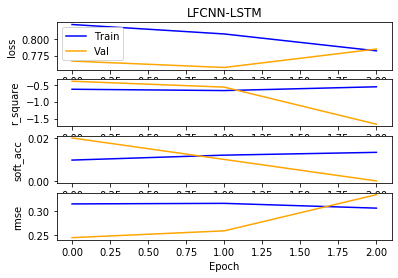

In [8]:
model.plot_history()

In [ ]:
model.compute_patterns(data_path=meta['train_paths'], output='patterns')
f = model.plot_patterns(sensor_layout='Vectorview-grad', sorting='best', scale=False)

In [ ]:
f3 = model.plot_spectra(sorting='best')

# 2. LFCNN

In [9]:
# refreshing the dataset model
dataset = mneflow.Dataset(meta, train_batch=100, class_subset=None, pick_channels=None, decim=None)

model = keras_models.LFCNN(graph_specs, dataset)
loss_f = tf.compat.v1.losses.mean_squared_error

# % builtin
model.compile(loss=loss_f, optimizer=optim, metrics=[r_square, soft_acc, rmse])

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=6)

#train the model
history = model.fit(dataset.train, validation_data=dataset.val, epochs=3, steps_per_epoch=100,
                    validation_steps=1, callbacks=[stop_early], verbose=1)

de-mix init : OK
fc init : OK
Epoch 1/3
[None, 102, 300]
input x0 (?, 102, 300, 1)
de-mix built : OK
dmx (?, 300, 1, 32)
conv build : OK
fc ::: 608 1
fc build : OK
100/100 [==============================] - 12s 116ms/step - loss: 0.5180 - r_square: -8.4608 - soft_acc: 0.0074 - rmse: 0.7043 - val_loss: 0.2148 - val_r_square: -0.7224 - val_soft_acc: 0.0200 - val_rmse: 0.2703
Epoch 2/3
100/100 [==============================] - 11s 106ms/step - loss: 0.3033 - r_square: -1.7925 - soft_acc: 0.0074 - rmse: 0.4003 - val_loss: 0.1924 - val_r_square: -0.2834 - val_soft_acc: 0.0000e+00 - val_rmse: 0.2333
Epoch 3/3
100/100 [==============================] - 10s 104ms/step - loss: 0.2468 - r_square: -0.7705 - soft_acc: 0.0154 - rmse: 0.3254 - val_loss: 0.1881 - val_r_square: -0.2455 - val_soft_acc: 0.0300 - val_rmse: 0.2298


In [10]:
model.summary()
results = model.evaluate(dataset.test, steps=1, verbose=1)

Model: "lf-cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
de-mix (DeMixing)            multiple                  3296      
_________________________________________________________________
conv (LFTConv)               multiple                  2080      
_________________________________________________________________
fc (Dense)                   multiple                  609       
Total params: 5,985
Trainable params: 5,985
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 184ms/step - loss: 0.2155 - r_square: -0.1774 - soft_acc: 0.0100 - rmse: 0.2831


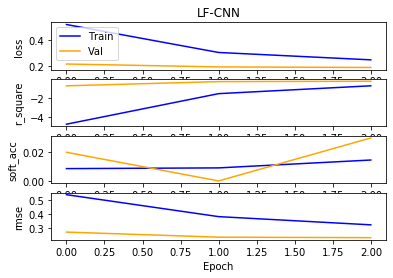

In [11]:
model.plot_history()

In [ ]:
model.compute_patterns(data_path=meta['train_paths'], output='patterns')
f = model.plot_patterns(sensor_layout='Vectorview-grad', sorting='best', scale=False)

In [ ]:
f3 = model.plot_spectra(sorting='best')

# 3. VARCNN

In [12]:
# refreshing the dataset model
dataset = mneflow.Dataset(meta, train_batch=100, class_subset=None, pick_channels=None, decim=None)

model = keras_models.VARCNN(graph_specs, dataset)
loss_f = tf.compat.v1.losses.mean_squared_error

# % builtin
model.compile(loss=loss_f, optimizer=optim, metrics=[r_square, soft_acc, rmse])

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=6)

#train the model
history = model.fit(dataset.train, validation_data=dataset.val, epochs=3, steps_per_epoch=100,
                    validation_steps=1, callbacks=[stop_early], verbose=1)

de-mix init : OK
conv init : OK
fc init : OK
Epoch 1/3
[None, 102, 300]
input x0 (?, 102, 300, 1)
de-mix built : OK
dmx (?, 300, 1, 32)
conv build : OK
conv call: ok shape (?, 19, 1, 32)
fc ::: 608 1
fc build : OK
100/100 [==============================] - 32s 317ms/step - loss: 6.5169 - r_square: -175.8453 - soft_acc: 0.0013 - rmse: 2.9979 - val_loss: 0.8893 - val_r_square: -4.7291 - val_soft_acc: 0.0000e+00 - val_rmse: 0.4929
Epoch 2/3
100/100 [==============================] - 31s 309ms/step - loss: 1.1017 - r_square: -7.8832 - soft_acc: 0.0054 - rmse: 0.7348 - val_loss: 0.8665 - val_r_square: -4.3131 - val_soft_acc: 0.0000e+00 - val_rmse: 0.4747
Epoch 3/3
100/100 [==============================] - 30s 302ms/step - loss: 0.8758 - r_square: -3.5263 - soft_acc: 0.0091 - rmse: 0.5181 - val_loss: 0.8047 - val_r_square: -2.9418 - val_soft_acc: 0.0200 - val_rmse: 0.4089


In [13]:
model.summary()
results = model.evaluate(dataset.test, steps=1, verbose=1)

Model: "var-cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
de-mix (DeMixing)            multiple                  3296      
_________________________________________________________________
conv (VARConv)               multiple                  65568     
_________________________________________________________________
fc (Dense)                   multiple                  609       
Total params: 69,473
Trainable params: 69,473
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 96ms/step - loss: 0.8401 - r_square: -1.9758 - soft_acc: 0.0000e+00 - rmse: 0.4501


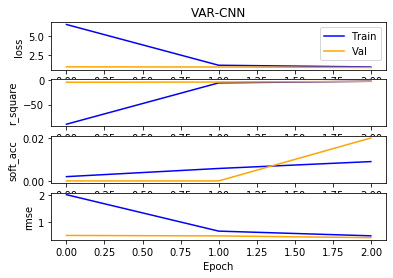

In [14]:
model.plot_history()